# Chunk Video Performance Analysis

This notebook analyzes the performance of `chunk_video_async` across different:
- Video lengths
- Chunk durations

We'll generate a heatmap showing execution time as a function of these parameters.


In [1]:
import asyncio
import json
import time
import os
import tempfile
from pathlib import Path

import aioboto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.video import chunk_video_async, get_video_metadata

# Create global aioboto3 session
aio_session = aioboto3.Session()


In [2]:
# Load video manifest
with open("video_manifest.json", "r") as f:
    manifest = json.load(f)

print(f"Total videos: {manifest['total_videos']}")
print(f"S3 Bucket: {manifest['s3_bucket']}")
print(f"S3 Prefix: {manifest['s3_prefix']}")

# Preview videos
videos_df = pd.DataFrame(manifest["videos"])
videos_df[["filename", "duration", "width", "height", "query"]]


Total videos: 20
S3 Bucket: abrar-test-bucket-123
S3 Prefix: stock-videos/


,filename,duration,width,height,query
0,kitchen_cooking_35395675_00.mp4,8,384,384,kitchen cooking
1,kitchen_cooking_3992465_01.mp4,24,384,384,kitchen cooking
2,kitchen_cooking_5036096_02.mp4,49,384,384,kitchen cooking
3,office_meeting_3255275_03.mp4,10,384,384,office meeting
4,office_meeting_3192305_04.mp4,26,384,384,office meeting
5,office_meeting_4629797_05.mp4,13,384,384,office meeting
6,street_city_traffic_35364266_06.mp4,12,384,384,street city traffic
7,street_city_traffic_35364241_07.mp4,10,384,384,street city traffic
8,street_city_traffic_35336575_08.mp4,44,384,384,street city traffic
9,living_room_home_4009958_09.mp4,34,384,384,living room home


In [3]:
# Async S3 utilities using aioboto3

async def get_presigned_url(s3_key: str, bucket: str = manifest["s3_bucket"], expiration: int = 3600) -> str:
    """Generate a presigned URL for an S3 object using aioboto3."""
    async with aio_session.client("s3") as s3:
        url = await s3.generate_presigned_url(
            "get_object",
            Params={"Bucket": bucket, "Key": s3_key},
            ExpiresIn=expiration
        )
        return url

async def download_s3_to_temp(bucket: str, key: str) -> str:
    """Download S3 object to a temporary file using aioboto3."""
    async with aio_session.client("s3") as s3:
        response = await s3.get_object(Bucket=bucket, Key=key)
        body = await response["Body"].read()
    
    # Write to temp file
    suffix = os.path.splitext(key)[1]
    with tempfile.NamedTemporaryFile(delete=False, suffix=suffix) as f:
        f.write(body)
        return f.name

async def download_s3_to_path(bucket: str, key: str, local_path: str) -> str:
    """Download S3 object to a specific path using aioboto3."""
    async with aio_session.client("s3") as s3:
        response = await s3.get_object(Bucket=bucket, Key=key)
        body = await response["Body"].read()
    
    with open(local_path, "wb") as f:
        f.write(body)
    return local_path

# Test with one video
test_video = manifest["videos"][0]
test_url = await get_presigned_url(test_video["s3_key"])
print(f"Test video: {test_video['filename']}")
print(f"Duration: {test_video['duration']}s")
print(f"Presigned URL generated successfully: {test_url[:80]}...")


Test video: kitchen_cooking_35395675_00.mp4
Duration: 8s
Presigned URL generated successfully: https://abrar-test-bucket-123.s3.amazonaws.com/stock-videos/kitchen_cooking_3539...


In [4]:
async def benchmark_chunk_video(
    video_url: str,
    chunk_duration: float,
    num_frames_per_chunk: int = 16,
    target_size: int = 384,
) -> dict:
    """
    Benchmark chunk_video_async for a single configuration.
    
    Returns dict with timing and metadata.
    """
    start_time = time.perf_counter()
    
    chunks = await chunk_video_async(
        video_url,
        chunk_duration=chunk_duration,
        num_frames_per_chunk=num_frames_per_chunk,
        target_size=target_size,
    )
    
    elapsed = time.perf_counter() - start_time
    
    return {
        "elapsed_seconds": elapsed,
        "num_chunks": len(chunks),
        "chunk_duration": chunk_duration,
    }


In [5]:
# Define chunk durations to test
CHUNK_DURATIONS = [2.0, 5.0, 10.0, 15.0, 20.0]

# All videos are now 384x384 - select diverse durations
videos_sorted = sorted(manifest["videos"], key=lambda v: v["duration"])

# Pick one video per 10-second bucket for diverse durations
duration_buckets = {}
for v in videos_sorted:
    bucket = (v["duration"] // 10) * 10  # Group by 10-second buckets
    if bucket not in duration_buckets:
        duration_buckets[bucket] = v

selected_videos = list(duration_buckets.values())
print(f"Selected {len(selected_videos)} videos with varying durations:")
for v in selected_videos:
    print(f"  - {v['filename']}: {v['duration']}s @ {v['width']}x{v['height']}")


Selected 6 videos with varying durations:
  - classroom_students_6209572_19.mp4: 4s @ 384x384
  - office_meeting_3255275_03.mp4: 10s @ 384x384
  - classroom_students_1580507_18.mp4: 22s @ 384x384
  - living_room_home_5813761_10.mp4: 30s @ 384x384
  - restaurant_cafe_5498709_12.mp4: 43s @ 384x384
  - living_room_home_6158703_11.mp4: 61s @ 384x384


In [6]:
# Run benchmarks
results = []

for video in selected_videos:
    video_url = await get_presigned_url(video["s3_key"])
    video_duration = video["duration"]
    
    print(f"\nBenchmarking: {video['filename']} ({video_duration}s)")
    
    for chunk_dur in CHUNK_DURATIONS:
        # Skip if chunk duration > video duration (not meaningful)
        if chunk_dur > video_duration:
            continue
        
        try:
            result = await benchmark_chunk_video(video_url, chunk_dur)
            
            results.append({
                "filename": video["filename"],
                "video_duration": video_duration,
                "video_resolution": f"{video['width']}x{video['height']}",
                "chunk_duration": chunk_dur,
                "elapsed_seconds": result["elapsed_seconds"],
                "num_chunks": result["num_chunks"],
            })
            
            print(f"  chunk_duration={chunk_dur}s: {result['elapsed_seconds']:.2f}s ({result['num_chunks']} chunks)")
        except Exception as e:
            print(f"  chunk_duration={chunk_dur}s: ERROR - {e}")

print(f"\n✓ Completed {len(results)} benchmarks")



Benchmarking: classroom_students_6209572_19.mp4 (4s)
  chunk_duration=2.0s: 0.48s (2 chunks)

Benchmarking: office_meeting_3255275_03.mp4 (10s)
  chunk_duration=2.0s: 0.92s (5 chunks)
  chunk_duration=5.0s: 0.62s (2 chunks)
  chunk_duration=10.0s: 0.64s (1 chunks)

Benchmarking: classroom_students_1580507_18.mp4 (22s)
  chunk_duration=2.0s: 1.75s (11 chunks)
  chunk_duration=5.0s: 1.10s (5 chunks)
  chunk_duration=10.0s: 0.68s (3 chunks)
  chunk_duration=15.0s: 0.68s (2 chunks)
  chunk_duration=20.0s: 0.73s (2 chunks)

Benchmarking: living_room_home_5813761_10.mp4 (30s)
  chunk_duration=2.0s: 2.03s (15 chunks)
  chunk_duration=5.0s: 0.99s (6 chunks)
  chunk_duration=10.0s: 0.68s (3 chunks)
  chunk_duration=15.0s: 0.69s (2 chunks)
  chunk_duration=20.0s: 0.69s (2 chunks)

Benchmarking: restaurant_cafe_5498709_12.mp4 (43s)
  chunk_duration=2.0s: 3.28s (22 chunks)
  chunk_duration=5.0s: 1.56s (9 chunks)
  chunk_duration=10.0s: 1.20s (5 chunks)
  chunk_duration=15.0s: 0.75s (3 chunks)
  c

In [7]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df


,filename,video_duration,video_resolution,chunk_duration,elapsed_seconds,num_chunks
0,classroom_students_6209572_19.mp4,4,384x384,2.0,0.478574,2
1,office_meeting_3255275_03.mp4,10,384x384,2.0,0.923646,5
2,office_meeting_3255275_03.mp4,10,384x384,5.0,0.621022,2
3,office_meeting_3255275_03.mp4,10,384x384,10.0,0.642984,1
4,classroom_students_1580507_18.mp4,22,384x384,2.0,1.746246,11
5,classroom_students_1580507_18.mp4,22,384x384,5.0,1.104896,5
6,classroom_students_1580507_18.mp4,22,384x384,10.0,0.675051,3
7,classroom_students_1580507_18.mp4,22,384x384,15.0,0.679118,2
8,classroom_students_1580507_18.mp4,22,384x384,20.0,0.732817,2
9,living_room_home_5813761_10.mp4,30,384x384,2.0,2.032840,15


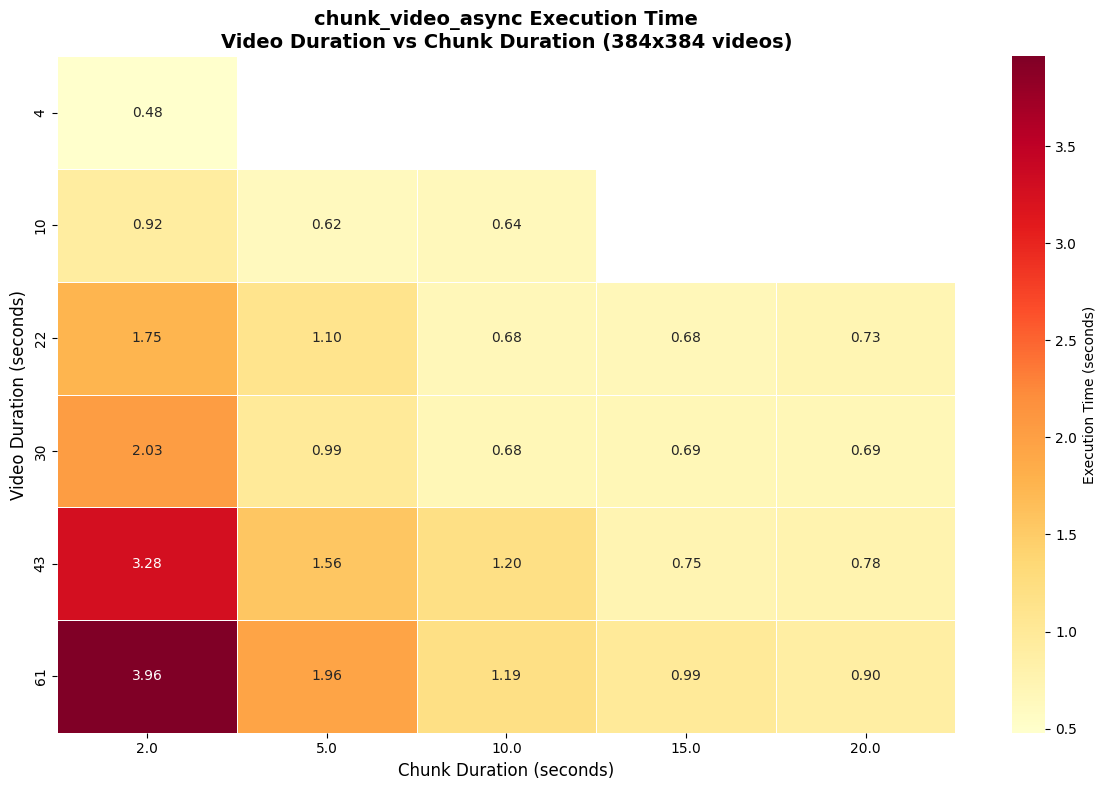

In [8]:
# Create heatmap: Video Duration vs Chunk Duration -> Execution Time
plt.figure(figsize=(12, 8))

# Pivot the data for heatmap
heatmap_data = results_df.pivot_table(
    index="video_duration",
    columns="chunk_duration",
    values="elapsed_seconds",
    aggfunc="mean"
)

# Sort index for better visualization
heatmap_data = heatmap_data.sort_index(ascending=True)

# Create heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    cbar_kws={"label": "Execution Time (seconds)"},
    linewidths=0.5,
)

plt.title("chunk_video_async Execution Time\nVideo Duration vs Chunk Duration (384x384 videos)", fontsize=14, fontweight="bold")
plt.xlabel("Chunk Duration (seconds)", fontsize=12)
plt.ylabel("Video Duration (seconds)", fontsize=12)
plt.tight_layout()
plt.savefig("assets/chunk_video_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()


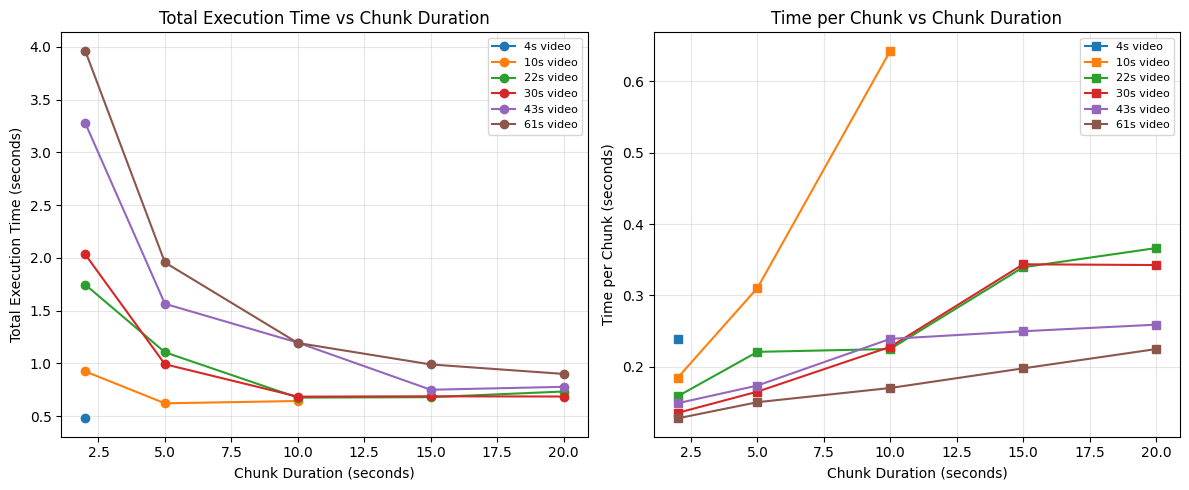

In [9]:
# Additional analysis: Execution time per chunk
results_df["time_per_chunk"] = results_df["elapsed_seconds"] / results_df["num_chunks"]

plt.figure(figsize=(12, 5))

# Plot 1: Total time by chunk duration
plt.subplot(1, 2, 1)
for duration in sorted(results_df["video_duration"].unique()):
    subset = results_df[results_df["video_duration"] == duration]
    plt.plot(
        subset["chunk_duration"],
        subset["elapsed_seconds"],
        marker="o",
        label=f"{duration}s video"
    )

plt.xlabel("Chunk Duration (seconds)")
plt.ylabel("Total Execution Time (seconds)")
plt.title("Total Execution Time vs Chunk Duration")
plt.legend(loc="best", fontsize=8)
plt.grid(True, alpha=0.3)

# Plot 2: Time per chunk by chunk duration
plt.subplot(1, 2, 2)
for duration in sorted(results_df["video_duration"].unique()):
    subset = results_df[results_df["video_duration"] == duration]
    plt.plot(
        subset["chunk_duration"],
        subset["time_per_chunk"],
        marker="s",
        label=f"{duration}s video"
    )

plt.xlabel("Chunk Duration (seconds)")
plt.ylabel("Time per Chunk (seconds)")
plt.title("Time per Chunk vs Chunk Duration")
plt.legend(loc="best", fontsize=8)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("assets/chunk_video_analysis.png", dpi=150, bbox_inches="tight")
plt.show()


In [10]:
# Summary statistics
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

print("\nBy Chunk Duration:")
chunk_summary = results_df.groupby("chunk_duration").agg({
    "elapsed_seconds": ["mean", "std", "min", "max"],
    "num_chunks": "mean",
    "time_per_chunk": "mean"
}).round(3)
print(chunk_summary)

print("\nBy Video Duration:")
video_summary = results_df.groupby("video_duration").agg({
    "elapsed_seconds": ["mean", "std", "min", "max"],
    "num_chunks": "mean",
}).round(3)
print(video_summary)


SUMMARY STATISTICS

By Chunk Duration:
               elapsed_seconds                      num_chunks time_per_chunk
                          mean    std    min    max       mean           mean
chunk_duration                                                               
2.0                      2.070  1.341  0.479  3.963     14.333          0.166
5.0                      1.247  0.520  0.621  1.956      7.000          0.204
10.0                     0.878  0.289  0.643  1.196      3.800          0.301
15.0                     0.776  0.145  0.679  0.989      3.000          0.283
20.0                     0.774  0.092  0.685  0.900      2.750          0.298

By Video Duration:
               elapsed_seconds                      num_chunks
                          mean    std    min    max       mean
video_duration                                                
4                        0.479    NaN  0.479  0.479      2.000
10                       0.729  0.169  0.621  0.924      2.667
22

# Sync vs Async Comparison

Compare `chunk_video` (sequential) vs `chunk_video_async` (parallel) using the longest video.


In [11]:
# Import sync version and download utility
from utils.video import chunk_video, chunk_video_async
import tempfile

# Find the longest video
longest_video = max(manifest["videos"], key=lambda v: v["duration"])
print(f"Longest video: {longest_video['filename']}")
print(f"Duration: {longest_video['duration']}s")
print(f"Resolution: {longest_video['width']}x{longest_video['height']}")


Longest video: living_room_home_6158703_11.mp4
Duration: 61s
Resolution: 384x384


In [30]:
# Download video locally for fair comparison (removes S3 network variability)
local_video_path = f"/tmp/{longest_video['filename']}"

# Download from S3 using aioboto3
print(f"Downloading {longest_video['s3_uri']} using aioboto3...")
await download_s3_to_path(
    manifest["s3_bucket"],
    longest_video["s3_key"],
    local_video_path
)

print(f"Downloaded to: {local_video_path}")


Downloaded to: /tmp/living_room_home_6158703_11.mp4


In [31]:
# Benchmark: chunk_video (sync/sequential) vs chunk_video_async (parallel)
CHUNK_DURATION = 10.0
NUM_RUNS = 3

print(f"Benchmarking with chunk_duration={CHUNK_DURATION}s, {NUM_RUNS} runs each")
print(f"Video: {longest_video['filename']} ({longest_video['duration']}s)")
print("=" * 60)

# Benchmark sync version
sync_times = []
for i in range(NUM_RUNS):
    start = time.perf_counter()
    chunks_sync = chunk_video(local_video_path, chunk_duration=CHUNK_DURATION)
    elapsed = time.perf_counter() - start
    sync_times.append(elapsed)
    print(f"  chunk_video (sync) run {i+1}: {elapsed:.3f}s ({len(chunks_sync)} chunks)")

# Benchmark async version
async_times = []
for i in range(NUM_RUNS):
    start = time.perf_counter()
    chunks_async = await chunk_video_async(local_video_path, chunk_duration=CHUNK_DURATION)
    elapsed = time.perf_counter() - start
    async_times.append(elapsed)
    print(f"  chunk_video_async run {i+1}: {elapsed:.3f}s ({len(chunks_async)} chunks)")

print("=" * 60)


Benchmarking with chunk_duration=10.0s, 3 runs each
Video: living_room_home_6158703_11.mp4 (61s)
  chunk_video (sync) run 1: 0.410s (7 chunks)
  chunk_video (sync) run 2: 0.411s (7 chunks)
  chunk_video (sync) run 3: 0.421s (7 chunks)
  chunk_video_async run 1: 0.452s (7 chunks)
  chunk_video_async run 2: 0.460s (7 chunks)
  chunk_video_async run 3: 0.440s (7 chunks)


RESULTS SUMMARY
chunk_video (sync):       0.414s ± 0.005s
chunk_video_async:        0.451s ± 0.008s
Speedup (async vs sync):  0.92x


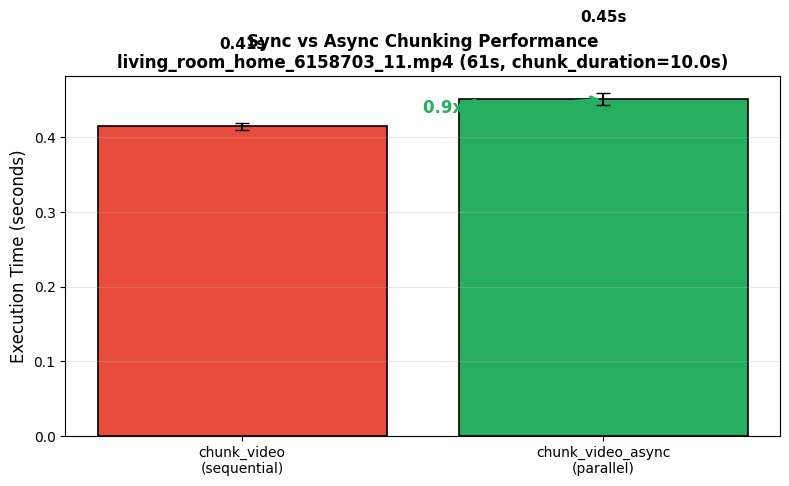

In [32]:
# Results comparison
sync_mean = np.mean(sync_times)
async_mean = np.mean(async_times)
speedup = sync_mean / async_mean

print("RESULTS SUMMARY")
print("=" * 60)
print(f"chunk_video (sync):       {sync_mean:.3f}s ± {np.std(sync_times):.3f}s")
print(f"chunk_video_async:        {async_mean:.3f}s ± {np.std(async_times):.3f}s")
print(f"Speedup (async vs sync):  {speedup:.2f}x")
print("=" * 60)

# Bar chart comparison
fig, ax = plt.subplots(figsize=(8, 5))

methods = ["chunk_video\n(sequential)", "chunk_video_async\n(parallel)"]
means = [sync_mean, async_mean]
stds = [np.std(sync_times), np.std(async_times)]
colors = ["#e74c3c", "#27ae60"]

bars = ax.bar(methods, means, yerr=stds, capsize=5, color=colors, edgecolor="black", linewidth=1.2)

ax.set_ylabel("Execution Time (seconds)", fontsize=12)
ax.set_title(f"Sync vs Async Chunking Performance\n{longest_video['filename']} ({longest_video['duration']}s, chunk_duration={CHUNK_DURATION}s)", 
             fontsize=12, fontweight="bold")
ax.grid(axis="y", alpha=0.3)

# Add value labels on bars
for bar, mean in zip(bars, means):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f"{mean:.2f}s", ha="center", va="bottom", fontsize=11, fontweight="bold")

# Add speedup annotation
ax.annotate(f"{speedup:.1f}x faster", 
            xy=(1, async_mean), xytext=(0.5, (sync_mean + async_mean)/2),
            fontsize=12, fontweight="bold", color="#27ae60",
            arrowprops=dict(arrowstyle="->", color="#27ae60", lw=2))

plt.tight_layout()
plt.savefig("assets/sync_vs_async_comparison.png", dpi=150, bbox_inches="tight")
plt.show()


In [35]:
# Benchmark: Single FFmpeg vs Multi-FFmpeg
# Uses the local video downloaded earlier

NUM_RUNS = 3
CHUNK_DURATIONS_TEST = [5.0, 10.0, 20.0]

print(f"Benchmarking Single FFmpeg vs Multi-FFmpeg")
print(f"Video: {longest_video['filename']} ({longest_video['duration']}s)")
print("=" * 70)

ffmpeg_comparison_results = []

for chunk_dur in CHUNK_DURATIONS_TEST:
    print(f"\nChunk duration: {chunk_dur}s")
    print("-" * 50)
    
    # Benchmark Multi-FFmpeg (parallel processes)
    multi_times = []
    for i in range(NUM_RUNS):
        start = time.perf_counter()
        chunks = await chunk_video_async(local_video_path, chunk_duration=chunk_dur, use_single_ffmpeg=False, ffmpeg_threads=2)
        elapsed = time.perf_counter() - start
        multi_times.append(elapsed)
        print(f"  Multi-FFmpeg  run {i+1}: {elapsed:.3f}s ({len(chunks)} chunks)")
    
    # Benchmark Single-FFmpeg (select filter)
    single_times = []
    for i in range(NUM_RUNS):
        start = time.perf_counter()
        chunks = await chunk_video_async(local_video_path, chunk_duration=chunk_dur, use_single_ffmpeg=True, ffmpeg_threads=6)
        elapsed = time.perf_counter() - start
        single_times.append(elapsed)
        print(f"  Single-FFmpeg run {i+1}: {elapsed:.3f}s ({len(chunks)} chunks)")
    
    ffmpeg_comparison_results.append({
        "chunk_duration": chunk_dur,
        "num_chunks": len(chunks),
        "multi_ffmpeg_mean": np.mean(multi_times),
        "multi_ffmpeg_std": np.std(multi_times),
        "single_ffmpeg_mean": np.mean(single_times),
        "single_ffmpeg_std": np.std(single_times),
    })

print("\n" + "=" * 70)

Benchmarking Single FFmpeg vs Multi-FFmpeg
Video: living_room_home_6158703_11.mp4 (61s)

Chunk duration: 5.0s
--------------------------------------------------
  Multi-FFmpeg  run 1: 0.643s (13 chunks)
  Multi-FFmpeg  run 2: 0.594s (13 chunks)
  Multi-FFmpeg  run 3: 0.602s (13 chunks)
  Single-FFmpeg run 1: 0.516s (13 chunks)
  Single-FFmpeg run 2: 0.518s (13 chunks)
  Single-FFmpeg run 3: 0.490s (13 chunks)

Chunk duration: 10.0s
--------------------------------------------------
  Multi-FFmpeg  run 1: 0.487s (7 chunks)
  Multi-FFmpeg  run 2: 0.477s (7 chunks)
  Multi-FFmpeg  run 3: 0.495s (7 chunks)
  Single-FFmpeg run 1: 0.437s (7 chunks)
  Single-FFmpeg run 2: 0.431s (7 chunks)
  Single-FFmpeg run 3: 0.436s (7 chunks)

Chunk duration: 20.0s
--------------------------------------------------
  Multi-FFmpeg  run 1: 0.381s (4 chunks)
  Multi-FFmpeg  run 2: 0.379s (4 chunks)
  Multi-FFmpeg  run 3: 0.384s (4 chunks)
  Single-FFmpeg run 1: 0.405s (4 chunks)
  Single-FFmpeg run 2: 0.386s

RESULTS: Single FFmpeg vs Multi-FFmpeg
 Chunk Dur   Chunks    Multi-FFmpeg   Single-FFmpeg    Speedup
----------------------------------------------------------------------
       5.0s     13.0        0.613s ± 0.021        0.508s ± 0.013      1.21x
      10.0s      7.0        0.486s ± 0.008        0.435s ± 0.003      1.12x
      20.0s      4.0        0.381s ± 0.002        0.404s ± 0.014      0.94x


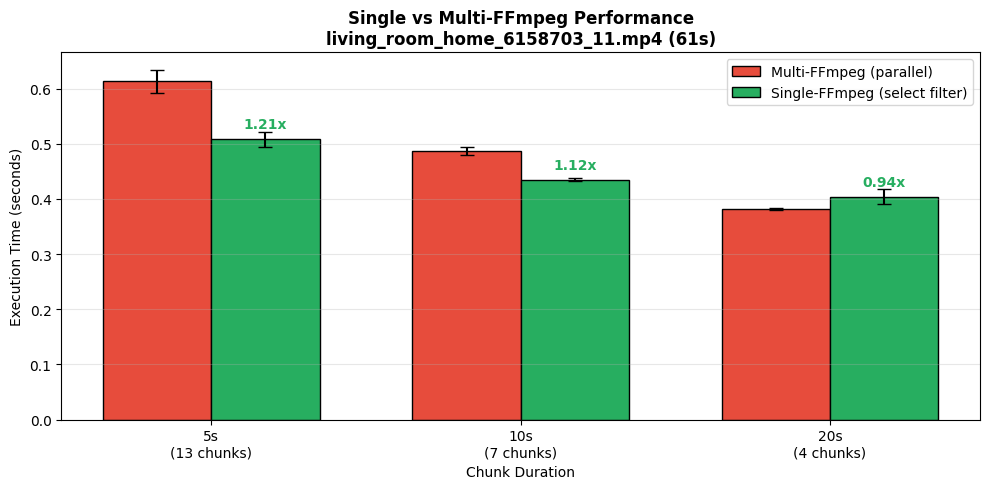

In [36]:
# Results visualization: Single FFmpeg vs Multi-FFmpeg
ffmpeg_comparison_df = pd.DataFrame(ffmpeg_comparison_results)
ffmpeg_comparison_df["speedup"] = ffmpeg_comparison_df["multi_ffmpeg_mean"] / ffmpeg_comparison_df["single_ffmpeg_mean"]

print("RESULTS: Single FFmpeg vs Multi-FFmpeg")
print("=" * 70)
print(f"{'Chunk Dur':>10} {'Chunks':>8} {'Multi-FFmpeg':>15} {'Single-FFmpeg':>15} {'Speedup':>10}")
print("-" * 70)

for _, row in ffmpeg_comparison_df.iterrows():
    print(f"{row['chunk_duration']:>10.1f}s {row['num_chunks']:>8} "
          f"{row['multi_ffmpeg_mean']:>12.3f}s ± {row['multi_ffmpeg_std']:.3f} "
          f"{row['single_ffmpeg_mean']:>12.3f}s ± {row['single_ffmpeg_std']:.3f} "
          f"{row['speedup']:>9.2f}x")

print("=" * 70)

# Bar chart
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(ffmpeg_comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, ffmpeg_comparison_df["multi_ffmpeg_mean"], width,
               yerr=ffmpeg_comparison_df["multi_ffmpeg_std"], capsize=5,
               label="Multi-FFmpeg (parallel)", color="#e74c3c", edgecolor="black")
bars2 = ax.bar(x + width/2, ffmpeg_comparison_df["single_ffmpeg_mean"], width,
               yerr=ffmpeg_comparison_df["single_ffmpeg_std"], capsize=5,
               label="Single-FFmpeg (select filter)", color="#27ae60", edgecolor="black")

ax.set_ylabel("Execution Time (seconds)")
ax.set_xlabel("Chunk Duration")
ax.set_title(f"Single vs Multi-FFmpeg Performance\n{longest_video['filename']} ({longest_video['duration']}s)", fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels([f"{int(d)}s\n({n} chunks)" for d, n in 
                   zip(ffmpeg_comparison_df["chunk_duration"], ffmpeg_comparison_df["num_chunks"])])
ax.legend()
ax.grid(axis="y", alpha=0.3)

# Add speedup annotations
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    speedup = ffmpeg_comparison_df.iloc[i]["speedup"]
    ax.annotate(f"{speedup:.2f}x", 
               xy=(bar2.get_x() + bar2.get_width()/2, bar2.get_height()),
               xytext=(0, 8), textcoords="offset points",
               ha="center", fontsize=10, fontweight="bold", color="#27ae60")

plt.tight_layout()
plt.savefig("assets/single_vs_multi_ffmpeg.png", dpi=150, bbox_inches="tight")
plt.show()

In [17]:
# Test with S3 presigned URL (where single-FFmpeg should benefit most)
print("Testing with S3 presigned URL...")
print("=" * 70)

test_url = await get_presigned_url(longest_video["s3_key"])
CHUNK_DUR = 10.0

# Multi-FFmpeg with URL
print(f"\nMulti-FFmpeg (multiple HTTP connections):")
multi_url_times = []
for i in range(NUM_RUNS):
    start = time.perf_counter()
    chunks = await chunk_video_async(test_url, chunk_duration=CHUNK_DUR, use_single_ffmpeg=False)
    elapsed = time.perf_counter() - start
    multi_url_times.append(elapsed)
    print(f"  Run {i+1}: {elapsed:.3f}s ({len(chunks)} chunks)")

# Single-FFmpeg with URL
print(f"\nSingle-FFmpeg (single HTTP stream):")
single_url_times = []
for i in range(NUM_RUNS):
    start = time.perf_counter()
    chunks = await chunk_video_async(test_url, chunk_duration=CHUNK_DUR, use_single_ffmpeg=True)
    elapsed = time.perf_counter() - start
    single_url_times.append(elapsed)
    print(f"  Run {i+1}: {elapsed:.3f}s ({len(chunks)} chunks)")

multi_mean = np.mean(multi_url_times)
single_mean = np.mean(single_url_times)
speedup = multi_mean / single_mean

print("\n" + "=" * 70)
print("RESULTS: S3 Presigned URL")
print("=" * 70)
print(f"Multi-FFmpeg:  {multi_mean:.3f}s ± {np.std(multi_url_times):.3f}s")
print(f"Single-FFmpeg: {single_mean:.3f}s ± {np.std(single_url_times):.3f}s")
print(f"Speedup:       {speedup:.2f}x")
print("=" * 70)

Testing with S3 presigned URL...

Multi-FFmpeg (multiple HTTP connections):
  Run 1: 1.289s (7 chunks)
  Run 2: 1.200s (7 chunks)
  Run 3: 1.237s (7 chunks)

Single-FFmpeg (single HTTP stream):
  Run 1: 0.737s (7 chunks)
  Run 2: 0.727s (7 chunks)
  Run 3: 0.734s (7 chunks)

RESULTS: S3 Presigned URL
Multi-FFmpeg:  1.242s ± 0.036s
Single-FFmpeg: 0.732s ± 0.004s
Speedup:       1.70x


# Presigned URL vs Direct S3 Download Performance

Compare video access methods:
1. **Presigned URL**: Generate URL with boto3, pass to ffmpeg (current approach)
2. **Direct S3 Download**: Download video bytes with aioboto3, save to temp file, then process


In [53]:
# Benchmark functions for presigned URL vs direct S3 comparison
# (aioboto3 session and download_s3_to_temp are defined in cell 3)

async def benchmark_presigned_url(video: dict, chunk_duration: float) -> dict:
    """Benchmark using presigned URL (ffmpeg streams directly from URL)."""
    start = time.perf_counter()
    
    url = await get_presigned_url(video["s3_key"])
    url_gen_time = time.perf_counter() - start
    
    chunks = await chunk_video_async(url, chunk_duration=chunk_duration, ffmpeg_threads=6, use_single_ffmpeg=True)
    total_time = time.perf_counter() - start
    
    return {
        "method": "presigned_url",
        "url_gen_time": url_gen_time,
        "total_time": total_time,
        "num_chunks": len(chunks),
    }

async def benchmark_direct_s3(video: dict, chunk_duration: float) -> dict:
    """Benchmark using direct S3 download with aioboto3."""
    start = time.perf_counter()
    
    # Download to temp file
    temp_path = await download_s3_to_temp(manifest["s3_bucket"], video["s3_key"])
    download_time = time.perf_counter() - start
    
    try:
        chunks = await chunk_video_async(temp_path, chunk_duration=chunk_duration, ffmpeg_threads=6, use_single_ffmpeg=True)
        total_time = time.perf_counter() - start
    finally:
        # Cleanup temp file
        os.unlink(temp_path)
    
    return {
        "method": "direct_s3_aioboto3",
        "download_time": download_time,
        "total_time": total_time,
        "num_chunks": len(chunks),
    }


In [54]:
# Run comparison benchmark
CHUNK_DURATION = 10.0
NUM_RUNS = 3

# Use a few videos of different sizes
test_videos = [
    next(v for v in manifest["videos"] if v["duration"] <= 10),   # Short
    next(v for v in manifest["videos"] if 20 <= v["duration"] <= 30),  # Medium
    next(v for v in manifest["videos"] if v["duration"] >= 40),   # Long
]

comparison_results = []

for video in test_videos:
    print(f"\n{'='*60}")
    print(f"Video: {video['filename']} ({video['duration']}s, {video['width']}x{video['height']})")
    print(f"{'='*60}")
    
    presigned_times = []
    direct_times = []
    
    for run in range(NUM_RUNS):
        # Benchmark presigned URL
        result_presigned = await benchmark_presigned_url(video, CHUNK_DURATION)
        presigned_times.append(result_presigned["total_time"])
        
        # Benchmark direct S3 download
        result_direct = await benchmark_direct_s3(video, CHUNK_DURATION)
        direct_times.append(result_direct["total_time"])
        
        print(f"  Run {run+1}: Presigned={result_presigned['total_time']:.2f}s, Direct S3={result_direct['total_time']:.2f}s (download={result_direct['download_time']:.2f}s)")
    
    comparison_results.append({
        "filename": video["filename"],
        "duration": video["duration"],
        "resolution": f"{video['width']}x{video['height']}",
        "presigned_mean": np.mean(presigned_times),
        "presigned_std": np.std(presigned_times),
        "direct_s3_mean": np.mean(direct_times),
        "direct_s3_std": np.std(direct_times),
    })

print(f"\n✓ Completed comparison benchmarks")



Video: kitchen_cooking_35395675_00.mp4 (8s, 384x384)
  Run 1: Presigned=0.44s, Direct S3=0.40s (download=0.24s)
  Run 2: Presigned=0.45s, Direct S3=0.40s (download=0.24s)
  Run 3: Presigned=0.46s, Direct S3=0.41s (download=0.25s)

Video: kitchen_cooking_3992465_01.mp4 (24s, 384x384)
  Run 1: Presigned=0.54s, Direct S3=0.52s (download=0.27s)
  Run 2: Presigned=0.52s, Direct S3=0.52s (download=0.27s)
  Run 3: Presigned=0.54s, Direct S3=0.50s (download=0.25s)

Video: kitchen_cooking_5036096_02.mp4 (49s, 384x384)
  Run 1: Presigned=0.77s, Direct S3=0.70s (download=0.29s)
  Run 2: Presigned=0.80s, Direct S3=0.70s (download=0.29s)
  Run 3: Presigned=0.76s, Direct S3=0.71s (download=0.29s)

✓ Completed comparison benchmarks


Comparison Results:
                       filename  duration resolution  presigned_mean  presigned_std  direct_s3_mean  direct_s3_std
kitchen_cooking_35395675_00.mp4         8    384x384        0.449107       0.005435        0.401356       0.007048
 kitchen_cooking_3992465_01.mp4        24    384x384        0.530370       0.009030        0.512359       0.009844
 kitchen_cooking_5036096_02.mp4        49    384x384        0.773435       0.016460        0.703364       0.005439


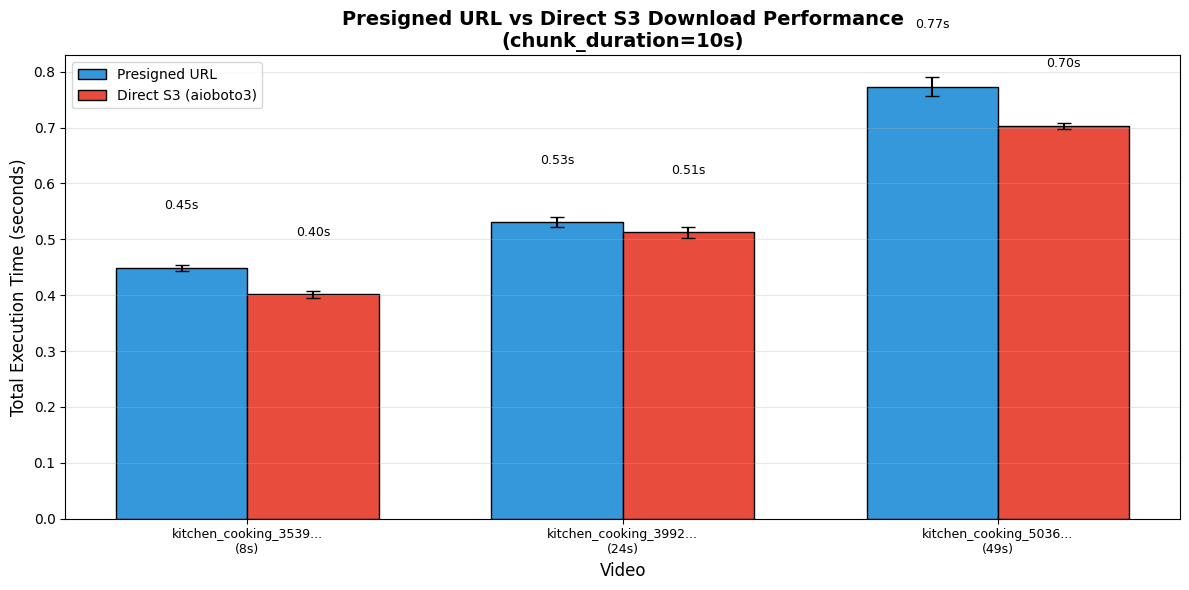


SUMMARY: Presigned URL vs Direct S3 Download
kitchen_cooking_35395675_00.mp: Direct S3 wins by 0.05s
kitchen_cooking_3992465_01.mp4: Direct S3 wins by 0.02s
kitchen_cooking_5036096_02.mp4: Direct S3 wins by 0.07s


In [55]:
# Visualize comparison results
comparison_df = pd.DataFrame(comparison_results)
print("Comparison Results:")
print(comparison_df.to_string(index=False))

# Calculate speedup
comparison_df["speedup"] = comparison_df["direct_s3_mean"] / comparison_df["presigned_mean"]

# Bar chart comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df["presigned_mean"], width, 
               yerr=comparison_df["presigned_std"], capsize=5,
               label="Presigned URL", color="#3498db", edgecolor="black")
bars2 = ax.bar(x + width/2, comparison_df["direct_s3_mean"], width,
               yerr=comparison_df["direct_s3_std"], capsize=5,
               label="Direct S3 (aioboto3)", color="#e74c3c", edgecolor="black")

ax.set_ylabel("Total Execution Time (seconds)", fontsize=12)
ax.set_xlabel("Video", fontsize=12)
ax.set_title("Presigned URL vs Direct S3 Download Performance\n(chunk_duration=10s)", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels([f"{r['filename'][:20]}...\n({r['duration']}s)" for _, r in comparison_df.iterrows()], fontsize=9)
ax.legend(loc="upper left")
ax.grid(axis="y", alpha=0.3)

# Add value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f"{bar.get_height():.2f}s", ha="center", va="bottom", fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
            f"{bar.get_height():.2f}s", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("assets/presigned_vs_direct_s3.png", dpi=150, bbox_inches="tight")
plt.show()

# Summary
print("\n" + "=" * 60)
print("SUMMARY: Presigned URL vs Direct S3 Download")
print("=" * 60)
for _, row in comparison_df.iterrows():
    winner = "Presigned URL" if row["presigned_mean"] < row["direct_s3_mean"] else "Direct S3"
    diff = abs(row["presigned_mean"] - row["direct_s3_mean"])
    print(f"{row['filename'][:30]}: {winner} wins by {diff:.2f}s")


In [26]:
# Cleanup
if os.path.exists(local_video_path):
    os.unlink(local_video_path)
    print(f"✓ Cleaned up {local_video_path}")


✓ Cleaned up /tmp/living_room_home_6158703_11.mp4
